In [218]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

from dataclasses import dataclass, field
from typing import Optional

DEVICE = torch.device('mps')

In [372]:
@dataclass
class CharacterTokenizer:
    decode_dict: dict[int, str] = field(default_factory=dict)
    encode_dict: dict[str, int] = field(default_factory=dict)

    def get_vocab(self):
        """Character to int mapping"""
        return self.encode_dict

    def train(self, input_str: str) -> None:
        """Determine what character will be mapped to which int using lexicograpical order"""
        chars = sorted(set(input_str))
        self.decode_dict: dict[int, str] = dict(enumerate(chars))
        self.encode_dict: dict[str, int] = {v:k for k,v in self.decode_dict.items()}

    def encode(self, input: str) -> list[int]:
        """Turn a string into a list of ints using a pretrained lookup table"""
        return [self.encode_dict[char] for char in input]

    def decode(self, tokens: list[int]) -> str:
        """Turn a list of ints into a string using a reverse lookup table"""
        return ''.join(self.decode_dict[token] for token in tokens)

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, block_size: int=256):
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.block_size = block_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        block_size = self.block_size
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {block_size=})'

    @classmethod
    def from_textfile(cls, filename: str, block_size: int=256) -> 'CharacterDataset':
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            tokenizer.train(data)
            return cls(data, tokenizer, block_size=block_size)

    def train_test_split(self, train_percentage: float=0.8) -> tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.tokenizer, self.block_size)

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.tokenizer, self.block_size)

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, idx: int) -> torch.tensor:
        # grab a chunk of block_size characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # use last character as target
        x = F.one_hot(tokens[:-1], num_classes=self.vocab_size).type(torch.float32).T
        y = tokens[-1:]
        return x,y

dataset = CharacterDataset.from_textfile('./input.txt', block_size=4)
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)
dataset[0][0].shape

torch.Size([65, 4])

In [708]:
class CNN1D(nn.Module):
    def __init__(self, vocab_size: int, block_size: int, conv_channels: int=128, use_bias: bool=False):
        super().__init__()
        assert block_size % 2 == 0, f'Invalid block_size, {block_size} is not an even number'
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.cnn = nn.Sequential(
            # conv block 1
            nn.LazyConv1d(out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            #nn.LayerNorm(block_size, bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv block 2
            nn.LazyConv1d(out_channels=conv_channels, kernel_size=3, padding='same', bias=use_bias),
            #nn.LayerNorm(int(block_size / 2), bias=use_bias),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # output projection
            nn.Flatten(1, -1),
            nn.LazyLinear(dataset.vocab_size, bias=use_bias)
        )
    
    def forward(self, X: torch.tensor, targets: Optional[torch.tensor]=None) -> tuple[torch.tensor, torch.tensor]:
        logits = self.cnn(X)
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits,loss

    def generate(self, n_samples: int=1, sample_length: int=256, temperature: float = 1.0) -> list[list[int]]:
        """Generate samples, probably want to be in eval mode for this"""
        device = next(self.parameters()).device
        idx = torch.zeros((n_samples, dataset.block_size), dtype=torch.long, device=device)
        
        for _ in trange(sample_length):
            input = F.one_hot(idx[:, -dataset.block_size:], dataset.vocab_size).to(torch.float).transpose(1,2)
            logits, _ = model(input)
            probs = F.softmax(logits / temperature, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)

        return idx[:,dataset.block_size:].tolist()

model = CNN1D(dataset.vocab_size, block_size=dataset.block_size).to(DEVICE)

model(dataset[0][0][None].to(DEVICE))

{k:v.numel() for k,v in model.named_parameters()}

{'cnn.0.weight': 24960, 'cnn.3.weight': 49152, 'cnn.7.weight': 66560}

In [705]:
X = train_dataset[0][0][None].to(DEVICE)
print(f'Input shape:\t\t{X.shape}\n')
for layer in model.cnn:
    X = layer(X)
    print(f'{layer.__class__.__name__} output shape:\t{X.shape}')
sum(p.numel() for p in model.parameters())

Input shape:		torch.Size([1, 65, 32])

Conv1d output shape:	torch.Size([1, 128, 32])
LayerNorm output shape:	torch.Size([1, 128, 32])
ReLU output shape:	torch.Size([1, 128, 32])
MaxPool1d output shape:	torch.Size([1, 128, 16])
Conv1d output shape:	torch.Size([1, 128, 16])
LayerNorm output shape:	torch.Size([1, 128, 16])
ReLU output shape:	torch.Size([1, 128, 16])
MaxPool1d output shape:	torch.Size([1, 128, 8])
Flatten output shape:	torch.Size([1, 1024])
Linear output shape:	torch.Size([1, 65])


190128

In [702]:
model = CNN1D(vocab_size=dataset.vocab_size, block_size=dataset.block_size)
dataloader = DataLoader(
    dataset=dataset,
    sampler=RandomSampler(dataset, replacement=False, num_samples=4000),
    batch_size=4
)
X,y = next(iter(dataloader))
pred,loss = model(X,y)

for sample in model.generate(temperature=.1):
    print(dataset.tokenizer.decode(sample))

  0%|          | 0/256 [00:00<?, ?it/s]

rvoWsWWWssWWoWXoWSWssssssjvfWWssssssfjfFSSSssssssssvBWsssssssKcccrSSSSfSsSXWWjrfsssssssssssssssf''WfWrrrrrrWJffsssssssAXf


j
sssffffffffNWsssssscjXjWssssssDjBfjfcBzsssss
BB
s
svssfsfrWffWsssssssXXsssssssf'frfNSSSssSX
WWXXrxAsssssjscsssKfssfWsjfffSWrAsss
s


  0%|          | 0/2000 [00:00<?, ?it/s]

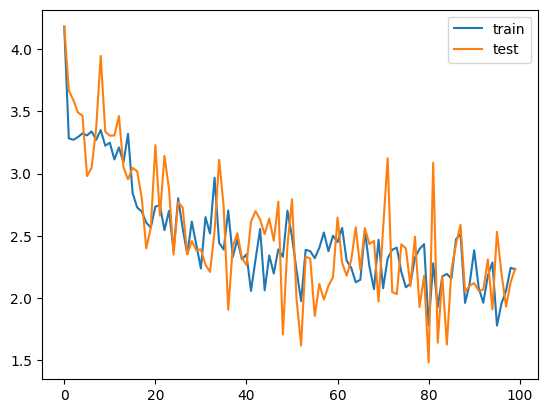

In [709]:
from tqdm.auto import tqdm,trange
from matplotlib import pyplot as plt
dataset = CharacterDataset.from_textfile('./input.txt', block_size=32)
model = CNN1D(vocab_size=dataset.vocab_size, block_size=dataset.block_size)
model.to(DEVICE)

train_steps = 2000
batch_size = 64

train_dataset,test_dataset = dataset.train_test_split()

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, replacement=True, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True, num_samples=20),
    batch_size=batch_size,
)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, betas=(0.9, 0.95))

train_losses = []
test_losses = []

for i,(x,y) in enumerate(tqdm(train_dataloader)):
    x,y = x.to(DEVICE), y.to(DEVICE)
    _,loss = model(x,y)
    if i % 20 == 0:
        train_losses.append(loss.item())
        test_loss = torch.tensor([model(test_x.to(DEVICE),test_y.to(DEVICE))[1] for test_x, test_y in test_dataloader])
        test_losses.append(torch.mean(test_loss).item())
    losses.append(loss.item())
    # backprop and update the parameters
    model.zero_grad()
    loss.backward()
    optimizer.step()
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [713]:
for sample in model.generate(n_samples=4, sample_length=128):
    print(dataset.tokenizer.decode(sample))

  0%|          | 0/128 [00:00<?, ?it/s]

IE:
Io, her mimhothes you the corslee tauw lork him bore lick thin cecorn? thoiknele whas bur in sbelrades daad cohce sly levers
EE:: I, hort non oolter,  outh pur.-

OINIUTASURnICMim: fou ind and arisse.

SIRRANM:
Worat at ant erecor:
Cather yoo be I then?
E,:
I, , the hit, my tourle, frout; sharlis me.

UAPETINL:W mriceie rirom:
Whed I Ot you trore afimengeants as art

REY:
Colnt w
I:
It, the, te, to tho yoe mow theld  of toy the the as peetrend udect nous sart;
Sumlle hate ridh are loess, tupe hit tip us:
T
